# Spinodal Decomposition (Part III)


## Introduction

In this notebook, we continue our analysis of the spinodal decomposition model.


### Scope of the work

 1. We load the data (see the detail description of the datasets in the Part I).
 2. We train a regression model, to predict the initial parameters from the final simulation output.
 3. We train a classifier, to predict the resulting morphology from the initial few frames of the simulation.


### Part I: A Short Overview

In the 1st notebook we focused on data exploration and clustering methods. We compared various feature vector representation and we determined the optimal number of clusters. We identified a morphology class for which the microstructures merge into characteristic, macroscopic, spanning clusters (SC). Finally, using the learning-by-confusion schema, we determined the threshold value for the transition between two main morphology classes.

### Part II: A Short Overview

In the 2nd notebook we focused on demonstrating the label propagation technique. We show how to train classifiers that are capable of detecting the SC without explicit access to the true labels (semi-supervised learning regime).


### The Background

 - We have training and test data generated with a help of a classical, resource-intensive simulation.
 - Each simulation describes evolution of two phases.
 - We are interested in learning the final morphology.
 - We have three different (initial) parameters that we can control: mobility of phase A, `mobA`, mobility of phase B, `mobB`, and phase fraction, `frac`.
 
 
### Motivation

 - **Goal 1:** We would like to learn if the morphologies can be logically grouped into a number of distinctive classes. If yes, we would like to create a morphology map.
 - **Goal 2:** We would like to train a model to predict the expected morphology type from the initial (few) frames of the classical simulation.

In this notebook, we focus on the second goal.

### Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import os
import json
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import numpy
import pandas
import scipy
import skimage.measure
import sklearn.cluster
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import tensorflow
import tensorflow_hub

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Input Data

To see the detail analysis of the input data, see the first notebook, "Spinodal Decomposition (Part I)".

The original simulations were saved as 101x512x512 dimensional numpy arrays, with `float64` numbers that range from around -1.05 to +1.05. Here, in order to save the space, we encoded the numbers as `float16`. Additionally, to make the input more similar to the input of some popular CNN architectures, we changed the dimensions of each frame from 512x512 to 256x256 (replacing every block of 2x2 pixels by the mean value).

The compression was performed by the following code,

```python
    assert original_data.dtype == 'float64' 
    assert original_data.shape == (4998, 101, 512, 512, 1)
    
    last_frame = original_data[:,-1]
    resized_data = skimage.measure.block_reduce(last_frame, (1, 2, 2, 1), numpy.mean)
    resized_data = resized_data.astype('float16')
    
    assert resized_data.dtype == 'float16' 
    assert resized_data.shape == (4998, 256, 256, 1)
```

There was originally 5000 training and 500 test simulations (generated for different initial parameters; the initial values of the parameters were selected randomly from uniform distributions). However, 2 training simulations were corrupted. Additionally, we selected 1000 training simulations (20%) to create a validation set. Therefore, the number of simulations used to construct the training set was 3998.

The input data have discrete translational symmetry (the input data is represented on a torus; we have periodic-boundary conditions both up-down and left-right). We leveraged it to to augment the training instances (see the Data Augmentation in Section 4 below).

### Data Location

All the input data can be found at the ISI server `effectbig03` in the `/data/mjabram/share/spinodal_decomposition` folder.

In [2]:
# If you run this notebook localy, change the path so it match the location of your main data folder
DATA_PATH = '/raw/cah/shared/'

### The Simulation Data

We load the simulation data. We use a dataset, that contains only the last frame of the simulation.
For our convenience (e.g., to make it compatible with the `plotlib`), we cast the data back from `float16` to `float32`. Note, this doesn't mean, that our accuracy of the input data increased to `float32`. We still have only about 4 significant digits per number. However, this should not be a problem, since the majority of pixel values are either close to +1 or to -1 (there is very little pixels with values close to zero; thus, even with a lower numerical precision, we can correctly identify the positive and negative regions). 

In [3]:
# Load the training data
data = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000x_256f16.npy')).astype('float32')
data.shape, data.dtype

((4998, 256, 256, 1), dtype('float32'))

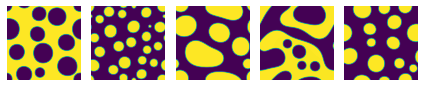

In [4]:
def plot_frames(data, *arr, cmap='viridis', title=None, axis=None):
    """Plot selected frames."""
    if title:
        print(title)
    fig, axes = plt.subplots(1, len(arr))
    for i, k in enumerate(arr):
        a = axes if len(arr) == 1 else axes[i]
        if not axis:
            a.axis('off');
        fig.tight_layout() 
        a.imshow(data[k], cmap=cmap)
    plt.show()

# Plot last frames from a few simulations
plot_frames(data, 0, 1, 2, 14, -1)  # note, we count the simulations from 0 not from 1

The original input ranges from around -1.04 to 1.04. However, most image recognition models expect the input to be in the `[0, 1]` range. Therefore, we clip the values that are below -1 or above 1, and then we rescale the input to be in the `[0, 1]` range.

(0.0, 1.0, 0.49998206)

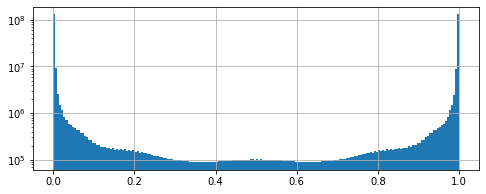

In [5]:
# Standarize the input data
data = numpy.where(data > 1, 1, data)
data = numpy.where(data < -1, -1, data)
data += 1
data /= 2

# Plot the distribution again (note, now the distribution is from 0 to 1)
fig, ax = plt.subplots()
pandas.Series(data.flatten()).hist(bins=200, figsize=(8, 3))
ax.set_yscale('log')
data.min(), data.max(), data.mean()

### Parameters

We load the initial parameters. There are three values for each simulation: the mobility of the phase A, `mobA`, the mobility of the phase B, `mobB`, and the phase fraction, `frac`.

The initial parameters were selected from uniform distributions. Mobility of the A and B phase were selected from `U(0, 100)`, while the phase fraction was selected from `U(-0.4, 0.4)`.

The phase fraction is (most likely; a confirmation is needed!) defined as `frac = phase A concentration - phase B concentration` with the constraint `phase A concentration + phase B concentration = 1`.

Again, for detail analysis, see the first notebook. We described there, e.g., a small discrepancy between the declared phase concentration and the measured one. However, we believe that this should not effect the results of this analysis.

In [6]:
# Load the parameters
parameters = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000p_256f16.npy'))
parameters = pandas.DataFrame(data=parameters, columns=['mobA', 'mobB', 'frac'])
parameters.tail()

,mobA,mobB,frac
4993,67.035086,46.664670,-0.158747
4994,94.223735,98.272281,0.148099
4995,2.031358,43.635881,0.238011
4996,14.542157,0.946535,0.029123
4997,18.476629,84.828663,-0.374032


### Connectivity Data

Looking at the simulations, we can notice that there are two obvious classes: one where the positive phase is dominant (yellow background, purple "bubbles") and another where the negative phase is dominant (purple background, yellow "bubbles"). However, as we will see in moment, we have also cases, that can not be easily accounted to one of those two classes.

We generated labels, checking if there is a path connecting pixels of one color from one edge to another edge. Specifically, we check if there is:
 - a vertical connection `v`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(k, 0)` to `(k, n-1)`.
 - a horizontal connection `h`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(0, k)` to `(n-1, k)`.
 
We assumed, that the connected path can be traveled only in vertical or horizontal directions. Meaning, that two pixels of one color that share one common corner are not connected.
 
We checked those connections with respect to:
 - both, negative phase (denoted as `neg` or `B`, and usually depicted by a purple color) and positive phase (denoted as `pos` or `A`, and usually depicted by a yellow color).
 - both, using and not-using the fact, that we have periodic boundary conditions (denoted below as `pbc`).

In [7]:
# Load and show the labels
connectivity = pandas.read_csv(os.path.join(DATA_PATH, 'cah_lastframe_train5000c_256f16.csv'))
connectivity.tail()

,pos,neg,pos_pbc,neg_pbc
4993,0,hv,0,hv
4994,hv,0,hv,0
4995,hv,0,hv,0
4996,0,0,hv,hv
4997,0,hv,0,hv


Note, that if both `pos=hv` and `neg=0`, it indicates that the positive phase is dominant (yellow background, purple "bubbles"). The opposite situation is when `pos=0` and `neg=hv`, then the negative phase is dominant (purple background, yellow bubbles).

However, there are a couple of examples that can not be easily classified as horizontal (h) or vertical (v). One of them are the simulations no. 4996 (see below). We will call those examples as _spanning clusters_ (SC). The name was chosen because if you account for the periodic boundary conditions, both negative and positive phase will have macroscopic (infinite) size.

The fact, that some cases were annotated as 0 in `pos` and `neg` but got non-zero value for `pos_pbc` and/or in `neg_pbc` usually means, that the spanning clusters are extended in the diagonal direction (see for example the simulation no. 2771).

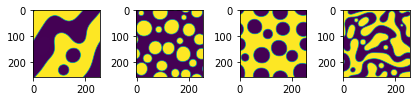

In [8]:
plot_frames(data, 2771, 4993, 4994, 4996, axis=True)

In [9]:
# Mark "spaning clusters" (sc), dominant positive (+), and dominant negative (-) cases
connectivity['sc'] = [int(row.pos != 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['+'] = [int(row.pos == 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['-'] = [int(row.pos != 'hv' and row.neg == 'hv') for _, row in connectivity.iterrows()]
connectivity.tail()

,pos,neg,pos_pbc,neg_pbc,sc,+,-
4993,0,hv,0,hv,0,0,1
4994,hv,0,hv,0,0,1,0
4995,hv,0,hv,0,0,1,0
4996,0,0,hv,hv,1,0,0
4997,0,hv,0,hv,0,0,1


**Summary:** The spanning clusters will become our central focus through this notebook. There are interesting, because they indicate a moment when the system switch from one main class of outcomes (phase A being connected and phase B being disconnected) to the second main class of outcomes (phase B being connected and phase A being disconnected).

We can also study this transition by analyzing the "natural scale" of the system. Approaching the transition, the size of the microscopic structures increases to reach macroscopic level. What is also characteristic, the final outcome become independent of the dynamical details of the system (namely, the mobility `mobA` and `mobB`). Those properties are part of the the universal scaling phenomena known from the statistical physics. 

### Feature Vectors (The Latent Space)

To create feature vector from an image we can use one of the pre-trained models available in TensorFlow Hub. Here, we decided to use the **ResNet V2** model. The key difference with the V1 is the use of batch normalization. ResNet 50 has 50 layers and was trained on standard ImageNet-1k detaset (ILSVRC-2012-CLS). The feature vector has size `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other input sizes are possible (within limits). See more at https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4.

Note, that this model require 3-channel input. Therefore, we will just triple our output (each channel will have the same pictures). The entire procedure was done using the following code,

```python
data3 = numpy.repeat(data, 3, axis=-1)

m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", trainable=False),
])
m.build([None, 256, 256, 3])

feature_vector = m.predict(data3)
```

Here, to safe time, we will load the pre-computed feature vector from a file.

In [10]:
# To save time, we will just load the feature vector that we already pre-computed.
feature_vector = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2.npy'))
feature_vector.shape

(4998, 2048)

### Training and Validation Dataset

We take random 80% of dataset for training and we leave rest for validation.

In [11]:
# Create training and validation set index
indexes = list(range(len(data)))

random.seed(123)  # just for the reproducibity, we set here a random number generator seed
random.shuffle(indexes)

train_n = int(len(data)*0.8)
train_idx = numpy.array(indexes[:train_n])
val_idx = numpy.array(indexes[train_n:])

train_idx[:5], train_idx.shape, val_idx[:5], val_idx.shape

(array([1823, 3764, 2702,  464,  994]),
 (3998,),
 array([1095, 1042, 2876, 3791, 3932]),
 (1000,))

In [12]:
# Create training and validation dataset
train_x = feature_vector[train_idx]
train_p = parameters.iloc[train_idx]
train_c = connectivity.iloc[train_idx]
train_data = data[train_idx]

val_x = feature_vector[val_idx]
val_p = parameters.iloc[val_idx]
val_c = connectivity.iloc[val_idx]
val_data = data[val_idx]

train_x.shape, train_p.shape, val_x.shape, val_p.shape, train_data.shape

((3998, 2048), (3998, 3), (1000, 2048), (1000, 3), (3998, 256, 256, 1))

## Section 2: Initial Parameter Prediction

We predict the initial parameters from the last frames.

In [13]:
m1 = tensorflow.keras.Sequential([
    tensorflow.keras.layers.Dense(512, activation='relu', input_shape=(2048,)),
    tensorflow.keras.layers.Dropout(0.25),
    tensorflow.keras.layers.Dense(1024, activation='relu'),
    tensorflow.keras.layers.Dropout(0.25),
    tensorflow.keras.layers.Dense(3, activation='linear')
])
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 1,577,475
Trainable params: 1,577,475
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Compile
m1.compile(
    optimizer=tensorflow.keras.optimizers.Adam(5e-5),
    loss=tensorflow.keras.losses.MeanSquaredError(),
    metrics=[
        tensorflow.keras.metrics.MeanAbsoluteError(name='mae'),
        tensorflow.keras.metrics.MeanAbsolutePercentageError(name='mape')],
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_mae', patience=2, min_delta=0.001, mode='min'
)

m1_log =  m1.fit(
    train_x, train_p, epochs=30, verbose=1, callbacks=[callback],
    validation_data=(val_x, val_p)
)

Epoch 1/30
125/125 [==============================] - 0s 3ms/step - loss: 1228.3486 - mae: 23.7967 - mape: 2095.1038 - val_loss: 533.9415 - val_mae: 16.2579 - val_mape: 336.8203
Epoch 2/30
125/125 [==============================] - 0s 2ms/step - loss: 461.9239 - mae: 15.2257 - mape: 1903.4994 - val_loss: 402.6580 - val_mae: 13.6807 - val_mape: 284.3004
Epoch 3/30
125/125 [==============================] - 0s 2ms/step - loss: 381.1730 - mae: 13.2966 - mape: 1582.2141 - val_loss: 356.1442 - val_mae: 12.2330 - val_mape: 253.5148
Epoch 4/30
125/125 [==============================] - 0s 2ms/step - loss: 349.2314 - mae: 12.4419 - mape: 1559.1122 - val_loss: 335.4197 - val_mae: 11.6966 - val_mape: 246.6927
Epoch 5/30
125/125 [==============================] - 0s 2ms/step - loss: 335.0625 - mae: 12.0627 - mape: 1956.4021 - val_loss: 327.6729 - val_mae: 11.5868 - val_mape: 281.4164
Epoch 6/30
125/125 [==============================] - 0s 2ms/step - loss: 328.4834 - mae: 11.8922 - mape: 1433.884

In [15]:
val_pred = pandas.DataFrame(m1.predict(val_x), columns=['mobA', 'mobB', 'frac'])
val_pred

,mobA,mobB,frac
0,29.864891,45.070511,0.228614
1,48.464794,53.257511,-0.298769
2,47.270699,77.586227,-0.218715
3,16.072918,47.886784,0.193068
4,46.074760,51.464523,0.042570
...,...,...,...
995,51.643520,24.079294,-0.238101
996,67.494591,51.796486,0.148885
997,46.785809,13.146588,-0.280179
998,8.321230,47.632427,0.079008


In [16]:
val_p.reset_index()

,index,mobA,mobB,frac
0,1095,27.911473,25.808916,0.344582
1,1042,94.078509,50.617573,-0.304685
2,2876,29.085166,74.834198,-0.231542
3,3791,17.131712,24.463983,0.298894
4,3932,27.649383,88.849111,0.068781
...,...,...,...,...
995,2183,56.310766,30.169234,-0.176134
996,3336,66.638817,14.263856,0.182307
997,714,47.395350,20.787280,-0.108672
998,2192,12.077042,4.382351,0.103654


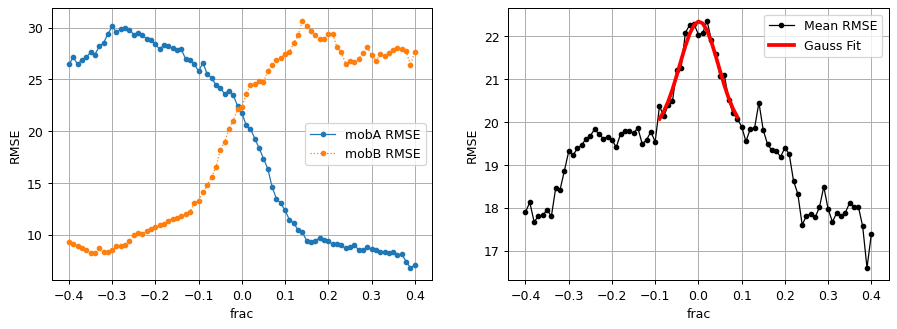

array([2.59838022e+00, 1.51621972e-03, 1.58310217e-02, 1.97545327e+01])

In [17]:
# Check the performance
rmse_mobA, rmse_mobB = [], []
frac = numpy.linspace(-0.4, 0.4, 81)
delta = 0.05
for f in frac:
    mask = numpy.abs(f - val_p.reset_index().frac) < delta    
    rmse_mobA.append(numpy.sqrt(
        sklearn.metrics.mean_squared_error(val_pred.mobA[mask], val_p.reset_index().mobA[mask])))
    rmse_mobB.append(numpy.sqrt(
        sklearn.metrics.mean_squared_error(val_pred.mobB[mask], val_p.reset_index().mobB[mask])))


rmse_mobA = numpy.array(rmse_mobA)
rmse_mobB = numpy.array(rmse_mobB)
av_rmse = numpy.add(rmse_mobA, rmse_mobB)/2
    
# Fit Gaussian
def gaussian(x, amplitude, mean, stddev, bias):
    """Return gaussian function in 1D."""
    return amplitude*numpy.exp(-((x - mean)/(4*stddev))**2) + bias

# Restrick yourself only to values close to the peak
peak_x = frac[31:50]
peak_y = av_rmse[31:50]
popt, _ = scipy.optimize.curve_fit(
    gaussian, peak_x, peak_y,
    p0=[1, 0, 0.01, 1]
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
axes[0].plot(frac, rmse_mobA, '.-', label='mobA RMSE', linewidth=1, markersize=7)
axes[0].plot(frac, rmse_mobB, '.:', label='mobB RMSE', linewidth=1, markersize=7)
axes[0].legend(); axes[0].grid(); axes[0].set_xlabel('frac'); axes[0].set_ylabel('RMSE')

axes[1].plot(frac, av_rmse, 'k.-', label='Mean RMSE', linewidth=1, markersize=7)
axes[1].plot(peak_x, gaussian(peak_x, *popt), 'r-', label='Gauss Fit', linewidth=3)
axes[1].legend(); axes[1].grid(); axes[1].set_xlabel('frac'); axes[1].set_ylabel('RMSE')
plt.show()

# Find the parameter value that corresponds to the peak
popt  # aplitude, mean value, std, bias

array([ 0.07227134, -0.02093455,  0.02289917,  0.06238653])

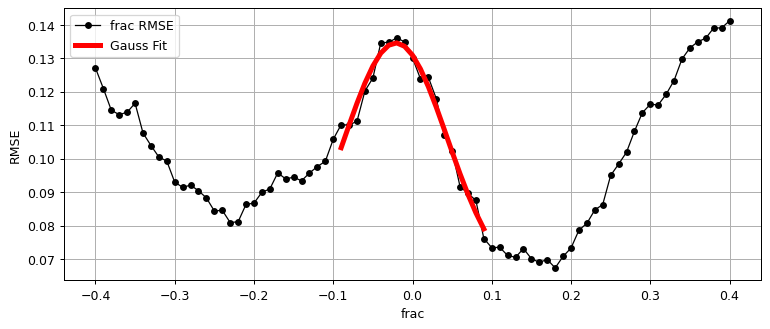

In [18]:
# Check the performance
rmse_frac = []
frac = numpy.linspace(-0.4, 0.4, 81)
delta = 0.05
for f in frac:
    mask = numpy.abs(f - val_p.reset_index().frac) < delta    
    rmse_frac.append(numpy.sqrt(
        sklearn.metrics.mean_squared_error(val_pred.frac[mask], val_p.reset_index().frac[mask])))
    
rmse_frac = numpy.array(rmse_frac)

# Fit Gaussian
def gaussian(x, amplitude, mean, stddev, bias):
    """Return gaussian function in 1D."""
    return amplitude*numpy.exp(-((x - mean)/(4*stddev))**2) + bias

# Restrick yourself only to values close to the peak
peak_x = frac[31:50]
peak_y = rmse_frac[31:50]
popt, _ = scipy.optimize.curve_fit(
    gaussian, peak_x, peak_y,
    p0=[1, 0, 0.01, 1]
)

fig, axes = plt.subplots(1, 1, figsize=(10, 4), dpi=90)
axes.plot(frac, rmse_frac, 'k.-', label='frac RMSE', linewidth=1, markersize=9)
axes.plot(peak_x, gaussian(peak_x, *popt), 'r-', label='Gauss Fit', linewidth=4)
axes.legend(); axes.grid(); axes.set_xlabel('frac'); axes.set_ylabel('RMSE')

# Find the parameter value that corresponds to the peak
popt  # aplitude, mean value, std, bias

### Mid-Summary

The accuracy of our predictions changes as we vary the parameters `frac`. This is a similar effect to the "Learning by Confussion" but more direct. The increase in the error is related to the universality property of the system in the critical point. Certain parameters become irrelevant - or in other words, some properties of the outcome becomes independent of the dynamical details of the system. This means, that we are not capable of predicting all of the initial parameters anymore, because the same outcome can be reached from various starting points. What is remarkable, we can measure it here directly.

By fitting a Gaussian, we can estimate the position of the critical point to be `frac = -0.02 +- 0.02`, which match our expectation (due to the symmetry of the problem, we should have `frac = 0`).